<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 1: Sem2 AY 23/24 - Convolutational Neural Networks (CNNs)

Module Leader: J.J. Collins

Students:  
- Pratik Verma - 23007575
- Siddharth Prince - 23052058

---
## Code checks
### Test cases
 1. Imports and setup - <span style='color: #0e0'>Passed</span>
 2. Data preprocessing and EDA - <span style='color: #0e0'>Passed</span>
 3. CNN architecture definition - <span style='color: #0e0'>Passed</span>
 4. Training - <span style='color: #0e0'>Passed</span>
 5. Metrics and evalutation - <span style='color: #0e0'>Passed</span>
 6. Finetuning model - <span style='color:orange'>waiting</span>
 7. Engineering overfitting/underfitting - <span style='color: #0e0'>Passed</span> (model is already overfitting)
---

## References
- [Sample Kaggle implementation with the Caltech-101 dataset](https://www.kaggle.com/code/ahmeddheyaa/caltech-101-image-classification/notebook)
- [Activity-6 notebook submission from semester 1 for module CE4051-Introduction to Data Engineering and Machine Learning](https://github.com/sprince0031/UL_Masters/blob/main/SEM_1/CE4051-Introduction_to_Data_Engineering_and_Machine_Learning/Week11_12/Activity6_23052058.ipynb)
- [Pytorch Alexnet sample](https://pytorch.org/hub/pytorch_vision_alexnet/)
- [Alexnet architecture code reference](https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py)

## 1. Imports and setup

In [1]:
import torch
from torch import nn # Importing torch's neural network (nn) class
import torch.nn.functional as F # importing this separately as 'F' to save the hasle of typing all that out. Also, it's funny.
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Caltech101
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
from torchvision import models

import matplotlib.pyplot as plt # Old faithful for plotting
import matplotlib.ticker as ticker
import numpy as np # It isn't a jupyter notebook running ML models without numpy, is it?
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import os
import time
from imutils import paths

import warnings 
warnings.filterwarnings('ignore') # To ignore the big red future warnings (we'll change our ways when things break and not premtively. 'Tis human nature.)

torch.manual_seed(69) # Setting a manual seed for consistency

In [2]:
# Pytorch version
torch.__version__

'2.2.1+cu121'

In [3]:
# Global variables
ROOT_DIR = './datasets/'
EPOCHS = 10
BATCH_SIZE = 16

### Selecting the device to use

In [5]:
# Get appropriate device for training
device = ( "cuda"     # CUDA to take advantage of Nvidia GPUs
           if torch.cuda.is_available()
           else "cpu" )   # If this fails -> CPU. Will probably use Google Colab and get a GPU.

print(f"{device} device available")

cpu device available


## 2. Data preprocessing and EDA

Below, we tried to compute the mean and standard deviation for the dataset based on the sample reference from a [pytorch forum thread](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/12). But, it turned out that the Caltech-101 dataset does not support this straightforward implementation because of a lack of test and train splits within the dataset iteself. Instead of going out of our way to do this again and re-invent the wheel, we decided to do what everyone else does and use the precomputed values of the ImageNet from the example implementations which seems to be widely accepted as the gold standard. [Reference](https://stackoverflow.com/a/57533806/5584011)

In [5]:
temp_transform = transforms.Compose([transforms.ToTensor()])
caltech101_data = Caltech101(root=root_dir, download=True, transform=temp_transform)


'''
The following code results in an error since the Caltech-101 dataset does not come with a partitioned training and testing set 
unlike other datasets such as CIFAR and MNIST.

mean = caltech101_data.train_data.mean(axis=(0,1,2))/255
std = mean = caltech101_data.train_data.std(axis=(0,1,2))/255
print(f'Mean values across the 3 colour channels for the Caltech101 data are {mean}')
print(f'Standard deviation values across the 3 colour channels for the Caltech101 data are {std}')
'''

NameError: name 'root_dir' is not defined

In [6]:
class Caltech101Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[index]
        return image, label

def load_dataset(dataset_path):
    image_paths, labels = [], []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                path = os.path.join(root, file)
                label = root.split(os.sep)[-1]
                if label != "BACKGROUND_Google":  # Exclude background images
                    image_paths.append(path)
                    labels.append(label)
    return image_paths, labels


In [7]:
# Path to your dataset
dataset_path = './datasets/caltech101/101_ObjectCategories'

# Load the dataset
image_paths, labels = load_dataset(dataset_path)

# Encode labels
lb = LabelBinarizer()
labels_binarised = lb.fit_transform(labels)
labels = np.argmax(labels_binarised, axis=1)  # Convert to indices for CrossEntropyLoss

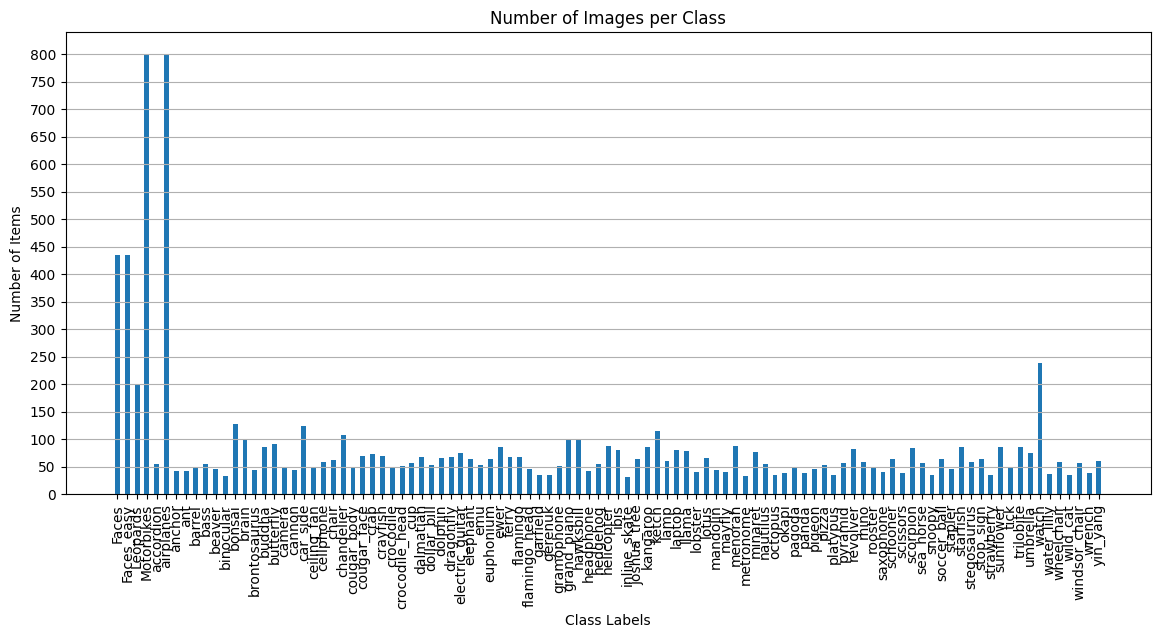

In [8]:
# Plotting a graph of the data distribution for each of the classes
labelCounts = labels_binarised.sum(axis=0)
plt.figure(figsize=(14, 6))
plt.bar(lb.classes_, labelCounts, width=0.5)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.xlabel('Class Labels')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Items')
plt.title('Number of Images per Class')
plt.grid(axis='y')
plt.show()

In [9]:
transform_temp = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = Caltech101Dataset(image_paths, labels, transform_temp)

loader = DataLoader(dataset,
                         batch_size=10,
                         num_workers=0,
                         shuffle=False,
                         drop_last=False)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
pixel_count = 0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
    pixel_count += images.nelement()
std = torch.sqrt(var / pixel_count)

print(f'Mean: {mean}, std: {std}')

Mean: tensor([0.5459, 0.5288, 0.5022]), std: tensor([0.1811, 0.1777, 0.1851])


In [10]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

In [11]:
# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5459, 0.5288, 0.5022], std=[0.1811, 0.1777, 0.1851])
])

# DataLoader
train_dataset = Caltech101Dataset(X_train, y_train, transform=transform)
test_dataset = Caltech101Dataset(X_test, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

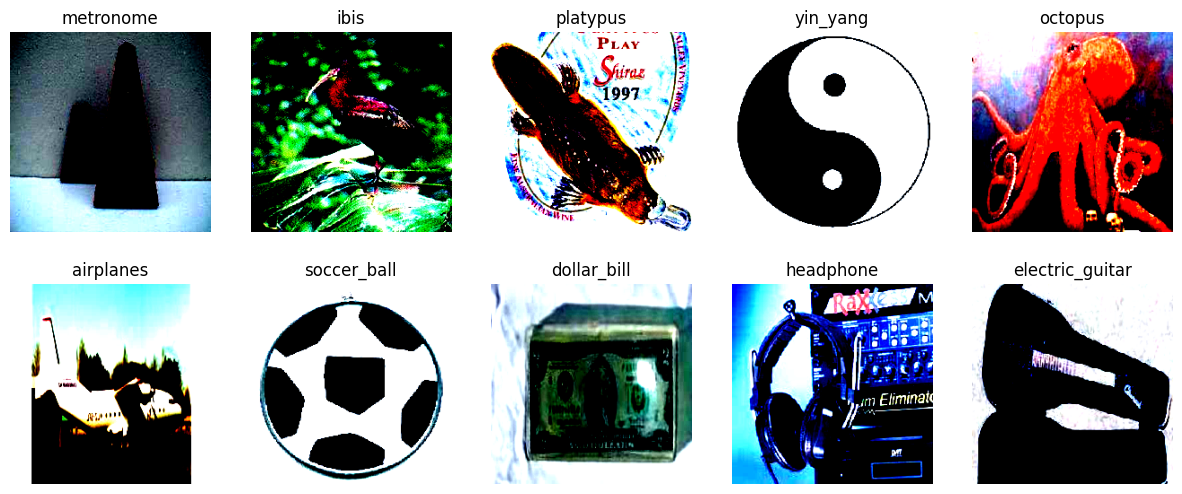

In [12]:
def show_images(images, labels, classes):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    axs = axs.flatten()
    for img, label, ax in zip(images, labels, axs):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
        ax.set_title(classes[label])
    plt.show()

# Assuming 'train_dataset' is already loaded and transformed
images, labels = next(iter(train_loader))
# Convert labels back to original encoding to get class names
classes = lb.classes_
show_images(images[:10], labels[:10], classes)

## 3. CNN Architecture Definition

In [11]:
class ZFNet(nn.Module):
    def __init__(self, num_classes=101):  # Assuming Caltech101 has 101 classes
        super(ZFNet, self).__init__()
        self.features = nn.Sequential(
            # The original ZFNet adjusted the filter size and stride in the first convolutional layer.
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [12]:
zfnet = ZFNet(num_classes=101).to(device)
summary(zfnet, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 112, 112]          14,208
              ReLU-2         [-1, 96, 112, 112]               0
         MaxPool2d-3           [-1, 96, 55, 55]               0
 LocalResponseNorm-4           [-1, 96, 55, 55]               0
            Conv2d-5          [-1, 256, 55, 55]         614,656
              ReLU-6          [-1, 256, 55, 55]               0
         MaxPool2d-7          [-1, 256, 27, 27]               0
 LocalResponseNorm-8          [-1, 256, 27, 27]               0
            Conv2d-9          [-1, 384, 27, 27]         885,120
             ReLU-10          [-1, 384, 27, 27]               0
           Conv2d-11          [-1, 384, 27, 27]       1,327,488
             ReLU-12          [-1, 384, 27, 27]               0
           Conv2d-13          [-1, 256, 27, 27]         884,992
             ReLU-14          [-1, 256,

## 4. Training

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   # 
        
        optimizer.zero_grad()               #<--- what is this for?
        
        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



In [14]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(zfnet.parameters(), lr=1e-3)

epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, zfnet, loss_fn, optimizer, epochs)

Epoch 1:

loss: 4.615171  [   32/ 6941]


KeyboardInterrupt: 

## 5. Metrics and evaluation

In [36]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot. 
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005
        
        plt.plot(X, y, label=label, marker=marker)
        
        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

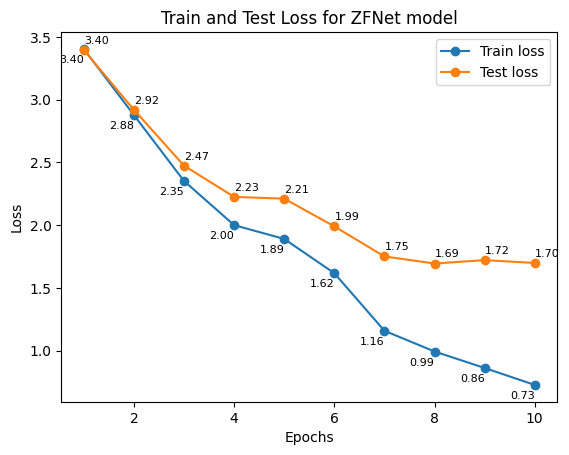

In [26]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.11, 'ha': 'right'}), 
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.05, 'ha': 'left'})]
plotTitle = 'Train and Test Loss for ZFNet model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

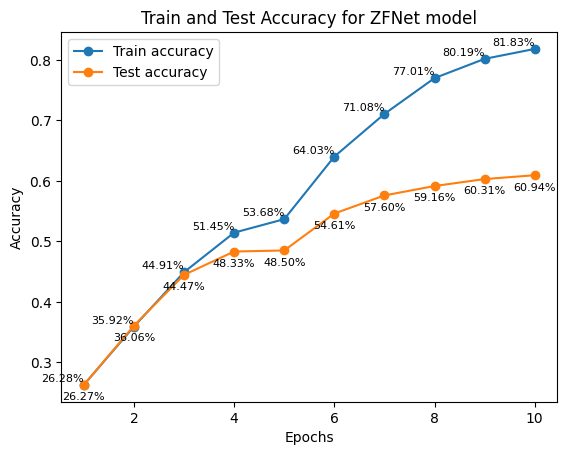

In [35]:
# Defining data and plot params
epochRange = range(1, epochs+1)
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.005,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'right'}), 
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.025,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for ZFNet model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Observations:
The model has a steady curve with both training and testing accuracies pretty much aligning until the 3rd epoch. After this, there is a small disparity between the two till epoch #5. But from here on out, it is pretty obvious that the model is overfitting to the training data as the testing accuracy is not growing nearly as much as the training accuracy.

## 6. Finetuning the model